In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Xf5VOkQi3NhfkldUYYHG")
project = rf.workspace("pallets-yfojl").project("adss-x9lpl")
version = project.version(1)
dataset = version.download("png-mask-semantic")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import cv2
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

In [ ]:
Image_h = 640
Image_w = 640
classes = 5
batch_size = 8
Epochs = 50

train = "/content/ADSS-1/train"
val = "/content/ADSS-1/valid"

class DataGenerator(Sequence):
    def __init__(self, folder_path, batch_size, Image_h, Image_w):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.Image_h = Image_h
        self.Image_w = Image_w
        self.files = [f for f in sorted(os.listdir(folder_path)) if f.endswith(".jpg")]

    def __len__(self):
        return int(np.ceil(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.files[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []

        for file in batch_files:
            image_path = os.path.join(self.folder_path, file)
            mask_path = os.path.join(self.folder_path, file.replace(".jpg", "_mask.png"))

            if os.path.exists(mask_path):
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (self.Image_h, self.Image_w))

                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (self.Image_h, self.Image_w), interpolation=cv2.INTER_NEAREST)

                img = img.astype(np.float32) / 255.0

                images.append(img)
                masks.append(mask)

        return np.array(images), np.array(masks)

train_gen = DataGenerator(train, batch_size, Image_h, Image_w)
val_gen = DataGenerator(val, batch_size, Image_h, Image_w)

def per_class_iou_metric(class_id):
    def iou(y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.int32)

        y_true_c = tf.where(tf.equal(y_true, class_id), 1.0, 0.0)
        y_pred_c = tf.where(tf.equal(y_pred, class_id), 1.0, 0.0)

        intersection = tf.reduce_sum(y_true_c * y_pred_c, axis=[1, 2])
        union = tf.reduce_sum(y_true_c, axis=[1, 2]) + tf.reduce_sum(y_pred_c, axis=[1, 2]) - intersection

        iou = (intersection + 1e-7) / (union + 1e-7)
        return tf.reduce_mean(iou)
    iou.__name__ = f'iou_class_{class_id}'
    return iou

def mean_iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    ious = []
    for c in range(classes):
        y_true_c = tf.where(tf.equal(y_true, c), 1.0, 0.0)
        y_pred_c = tf.where(tf.equal(y_pred, c), 1.0, 0.0)

        intersection = tf.reduce_sum(y_true_c * y_pred_c, axis=[1, 2])
        union = tf.reduce_sum(y_true_c, axis=[1, 2]) + tf.reduce_sum(y_pred_c, axis=[1, 2]) - intersection

        iou = (intersection + 1e-7) / (union + 1e-7)
        ious.append(iou)

    mean_iou_val = tf.reduce_mean(tf.stack(ious, axis=0), axis=0)
    return tf.reduce_mean(mean_iou_val)

def foreground_mean_iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)

    ious = []
    for c in range(1, classes):
        y_true_c = tf.where(tf.equal(y_true, c), 1.0, 0.0)
        y_pred_c = tf.where(tf.equal(y_pred, c), 1.0, 0.0)

        intersection = tf.reduce_sum(y_true_c * y_pred_c, axis=[1, 2])
        union = tf.reduce_sum(y_true_c + y_pred_c, axis=[1, 2]) - intersection

        iou = (intersection + 1e-7) / (union + 1e-7)
        ious.append(iou)

    return tf.reduce_mean(tf.stack(ious, axis=0))

def dice_loss(y_true, y_pred, smooth=1e-7):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=classes)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return ce_loss + d_loss

def enhanced_unet(input_shape, num_classes=5):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.05)(p1)

    c2 = layers.Conv2D(96, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(96, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.1)(p2)

    c3 = layers.Conv2D(192, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(192, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.15)(p3)

    c4 = layers.Conv2D(384, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(384, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(0.2)(p4)

    c5 = layers.Conv2D(768, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(768, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.25)(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Conv2D(384, (2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    u6 = layers.BatchNormalization()(u6)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(0.2)(u6)
    c6 = layers.Conv2D(384, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(384, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Conv2D(192, (2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    u7 = layers.BatchNormalization()(u7)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(0.15)(u7)
    c7 = layers.Conv2D(192, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(192, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.Conv2D(96, (2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    u8 = layers.BatchNormalization()(u8)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(0.1)(u8)
    c8 = layers.Conv2D(96, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(96, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.Conv2D(48, (2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    u9 = layers.BatchNormalization()(u9)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(0.05)(u9)
    c9 = layers.Conv2D(48, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(48, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    c9 = layers.BatchNormalization()(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    return Model(inputs, outputs)

model = enhanced_unet((Image_h, Image_w, 3), num_classes=classes)
metrics_list = [mean_iou, foreground_mean_iou] + [per_class_iou_metric(i) for i in range(classes)]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=metrics_list
)

model.summary()

callbacks = [
    EarlyStopping(patience=5, monitor='val_foreground_mean_iou', mode='max', restore_best_weights=True),
    ModelCheckpoint('AV_semantic_segmentation_best.keras', monitor='val_foreground_mean_iou', mode='max', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=Epochs,
    callbacks=callbacks
)

save_path = '/content/drive/My Drive/AV_semantic_segmentation.keras'
model.save(save_path)

print("AV segmentation model training and saving complete!")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 640, 640, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 640, 640, 48)   │          1,344 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_88    │ (None, 640, 640, 48)   │            192 │ conv2d_92[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 640, 640, 48)   │         20,784 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_89    │ (None, 640, 640, 48)   │            192 │ conv2d_93[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 320, 320, 48)   │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 320, 320, 48)   │              0 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 320, 320, 96)   │         41,568 │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_90    │ (None, 320, 320, 96)   │            384 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 320, 320, 96)   │         83,040 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_91    │ (None, 320, 320, 96)   │            384 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 160, 160, 96)   │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_37 (Dropout)      │ (None, 160, 160, 96)   │              0 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 160, 160, 192)  │        166,080 │ dropout_37[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_92    │ (None, 160, 160, 192)  │            768 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)   

 Total params: 17,477,717 (66.67 MB)

 Trainable params: 17,467,445 (66.63 MB)

 Non-trainable params: 10,272 (40.12 KB)

Epoch 1/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 334s 284ms/step - foreground_mean_iou: 0.0741 - iou_class_0: 0.7266 - iou_class_1: 0.0242 - iou_class_2: 0.0286 - iou_class_3: 0.0042 - iou_class_4: 0.2393 - loss: 2.0830 - mean_iou: 0.2046 - val_foreground_mean_iou: 0.4553 - val_iou_class_0: 0.9084 - val_iou_class_1: 0.6439 - val_iou_class_2: 0.6152 - val_iou_class_3: 0.2245 - val_iou_class_4: 0.3377 - val_loss: 1.2309 - val_mean_iou: 0.5459 - learning_rate: 1.0000e-04
Epoch 2/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 269s 259ms/step - foreground_mean_iou: 0.4278 - iou_class_0: 0.9156 - iou_class_1: 0.5492 - iou_class_2: 0.4612 - iou_class_3: 0.3041 - iou_class_4: 0.3968 - loss: 1.1969 - mean_iou: 0.5254 - val_foreground_mean_iou: 0.5923 - val_iou_class_0: 0.9140 - val_iou_class_1: 0.7083 - val_iou_class_2: 0.6379 - val_iou_class_3: 0.6403 - val_iou_class_4: 0.3826 - val_loss: 1.0383 - val_mean_iou: 0.6566 - learning_rate: 1.0000e-04
Epoch 3/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 269s 258ms/step - foregrou

In [ ]:
model = load_model('/content/drive/My Drive/AV_semantic_segmentation.keras',compile=False)

test_folder = "/content/ADSS-1/test"
Image_h, Image_w = 640, 640

def preprocess_image(image_path, target_size=(Image_h, Image_w)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return np.expand_dims(image, axis=0)

test_images = [f for f in os.listdir(test_folder) if f.endswith('.jpg')]

output_folder = "/content/drive/MyDrive/test_predictions"
os.makedirs(output_folder, exist_ok=True)

colors = [
    (0, 0, 0),      # Background - Black
    (255, 0, 0),    # Blue
    (0, 255, 0),    # Green
    (0, 0, 255),    # Red
    (255, 255, 0)   # Cyan
]

iou_scores = []
class_iou_scores = {i: [] for i in range(5)}

for image_name in test_images:
    image_path = os.path.join(test_folder, image_name)
    input_image = preprocess_image(image_path)

    predicted_mask = model.predict(input_image)[0]
    print(f"Raw predicted_mask shape: {predicted_mask.shape}, dtype: {predicted_mask.dtype}")

    predicted_class = np.argmax(predicted_mask, axis=-1)
    print(f"Predicted class shape: {predicted_class.shape}, unique classes: {np.unique(predicted_class)}")

    class_mask = predicted_class.astype(np.uint8)
    class_mask_path = os.path.join(output_folder, image_name.replace('.jpg', '_class_mask.png'))
    cv2.imwrite(class_mask_path, class_mask)

    original_img = cv2.imread(image_path)
    original_img = cv2.resize(original_img, (Image_h, Image_w))

    vis_mask = np.zeros((Image_h, Image_w, 3), dtype=np.uint8)
    for class_idx in range(len(colors)):
        vis_mask[predicted_class == class_idx] = colors[class_idx]

    alpha = 0.6
    overlay = cv2.addWeighted(original_img, 1 - alpha, vis_mask, alpha, 0)

    vis_path = os.path.join(output_folder, image_name.replace('.jpg', '_visualization.png'))
    cv2.imwrite(vis_path, overlay)

    color_mask_path = os.path.join(output_folder, image_name.replace('.jpg', '_color_mask.png'))
    cv2.imwrite(color_mask_path, vis_mask)

    print(f"Saved predictions for {image_name}")

    true_mask_path = os.path.join(test_folder, image_name.replace('.jpg', '_mask.png'))
    if not os.path.exists(true_mask_path):
        print(f"Warning: Ground truth mask not found for {image_name}")
        continue

    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.resize(true_mask, (Image_h, Image_w), interpolation=cv2.INTER_NEAREST)

    pred_mask = predicted_class

    class_ious = {}
    for class_idx in range(5):
        true_binary = (true_mask == class_idx).astype(np.uint8)
        pred_binary = (pred_mask == class_idx).astype(np.uint8)

        if np.sum(true_binary) == 0 and np.sum(pred_binary) == 0:
            class_iou = 1.0
        elif np.sum(true_binary) == 0 or np.sum(pred_binary) == 0:
            class_iou = 0.0
        else:
            intersection = np.logical_and(true_binary, pred_binary).sum()
            union = np.logical_or(true_binary, pred_binary).sum()
            class_iou = intersection / union if union > 0 else 0.0

        class_ious[class_idx] = class_iou
        class_iou_scores[class_idx].append(class_iou)

    image_miou = sum(class_ious.values()) / len(class_ious)
    iou_scores.append(image_miou)

    print(f"IoU for {image_name}:")
    for class_idx, iou in class_ious.items():
        print(f"  Class {class_idx}: {iou:.4f}")
    print(f"  Mean IoU: {image_miou:.4f}")

    color_mask = np.zeros((Image_h, Image_w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(colors):
        color_mask[pred_mask == class_idx] = color

    vis_path = os.path.join(output_folder, image_name.replace('.jpg', '_prediction.png'))
    cv2.imwrite(vis_path, color_mask)

mean_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0
print("\nOverall Results:")
print(f"Mean IoU across all images: {mean_iou:.4f}")

print("\nClass-wise Mean IoU:")
for class_idx in range(5):
    class_mean_iou = sum(class_iou_scores[class_idx]) / len(class_iou_scores[class_idx]) if class_iou_scores[class_idx] else 0
    print(f"Class {class_idx}: {class_mean_iou:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw predicted_mask shape: (640, 640, 5), dtype: float32
Predicted class shape: (640, 640), unique classes: [0 4]
Saved predictions for image_002748_jpg.rf.1f874ec4e81a09a0a4190614e13991ff.jpg
IoU for image_002748_jpg.rf.1f874ec4e81a09a0a4190614e13991ff.jpg:
  Class 0: 0.9739
  Class 1: 1.0000
  Class 2: 1.0000
  Class 3: 1.0000
  Class 4: 0.8822
  Mean IoU: 0.9712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Raw predicted_mask shape: (640, 640, 5), dtype: float32
Predicted class shape: (640, 640), unique classes: [0]
Saved predictions for image_004788_jpg.rf.d429848d7acaf3d1aef7109a4ea6b4ed.jpg
IoU for image_004788_jpg.rf.d429848d7acaf3d1aef7109a4ea6b4ed.jpg:
  Class 0: 1.0000
  Class 1: 1.0000
  Class 2: 1.0000
  Class 3: 1.0000
  Class 4: 1.0000
  Mean IoU: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Raw predicted_mask shape: (640, 640, 5), dtype: float32
Predicted class shape: (640, 640), unique classes: [0 4]
Saved predictions for image_002403_jpg.rf.5

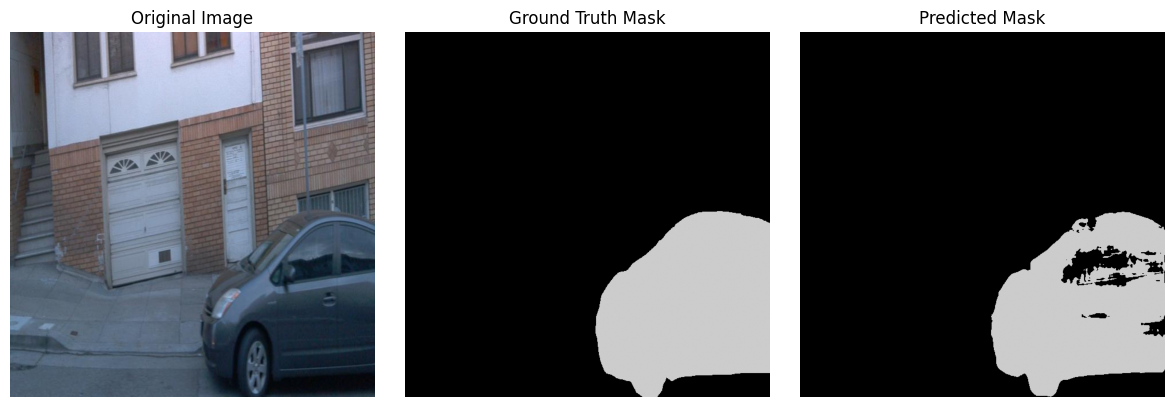

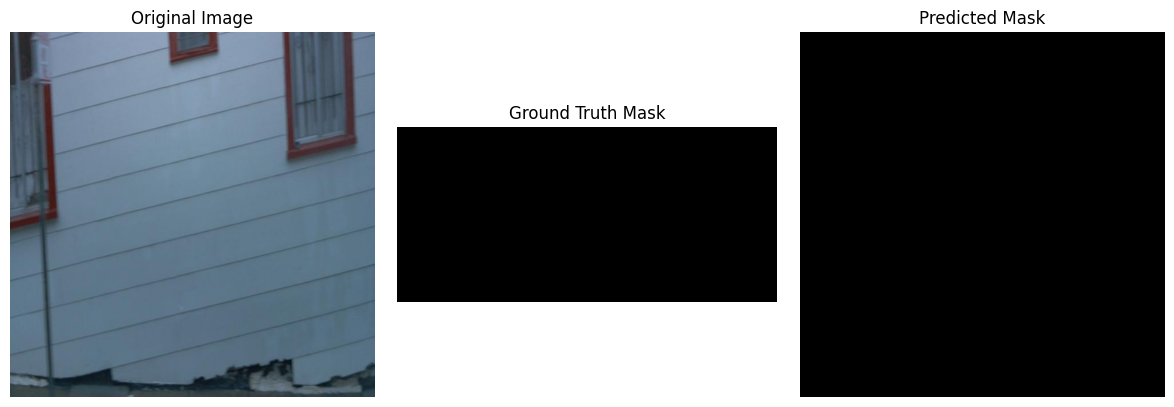

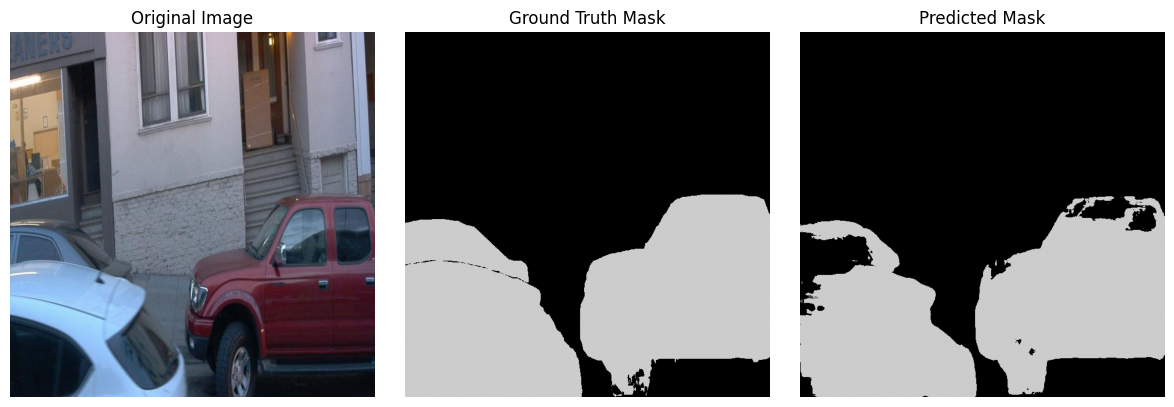

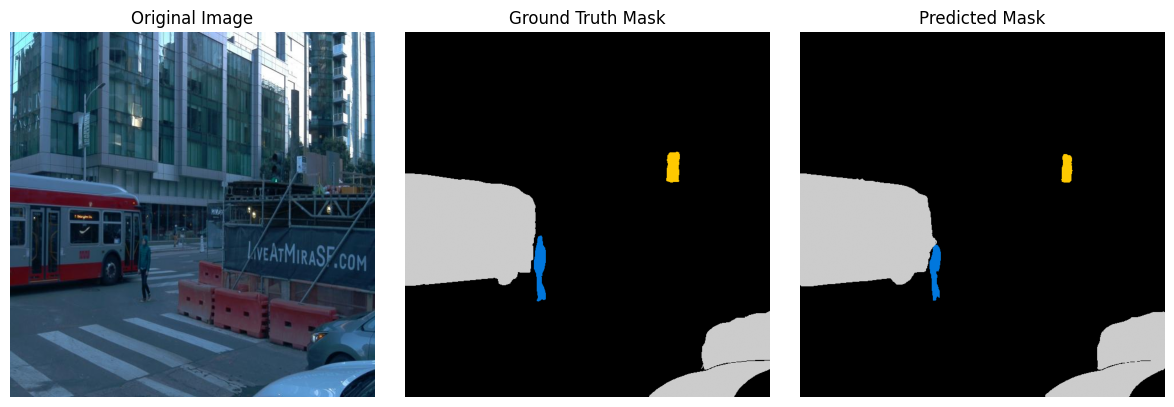

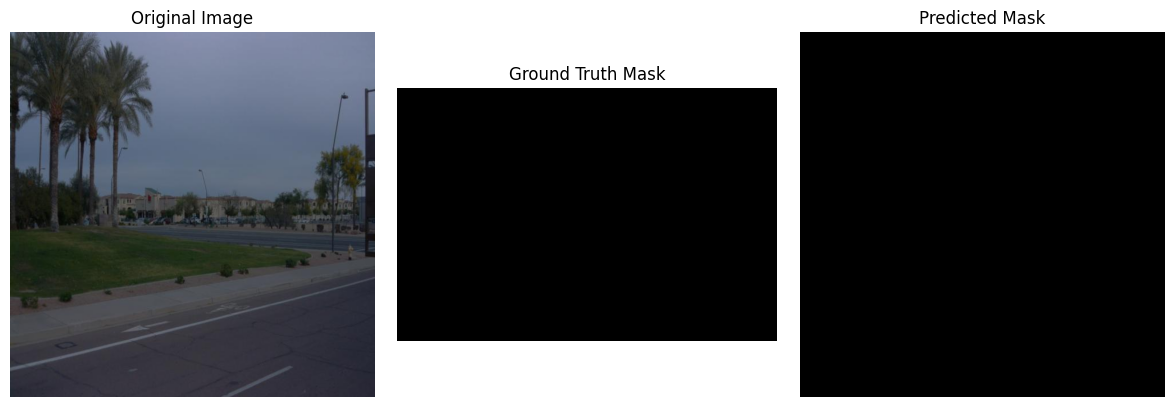

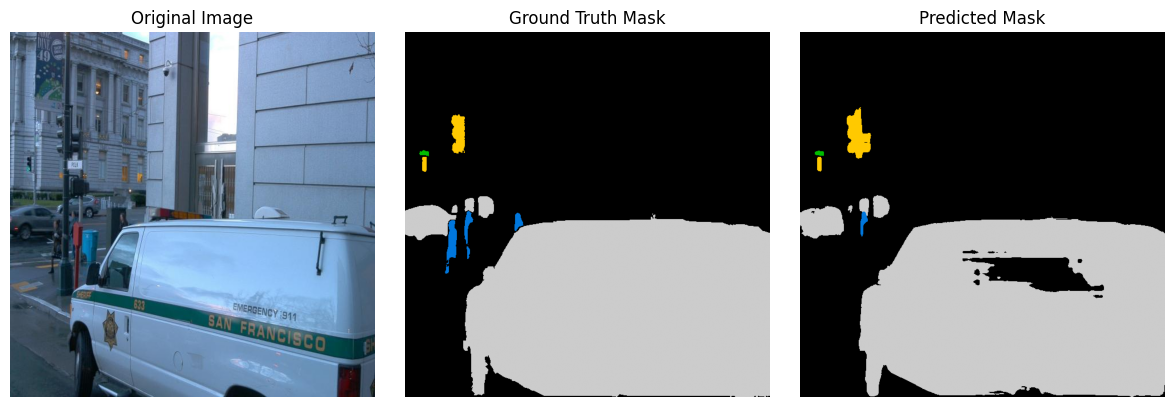

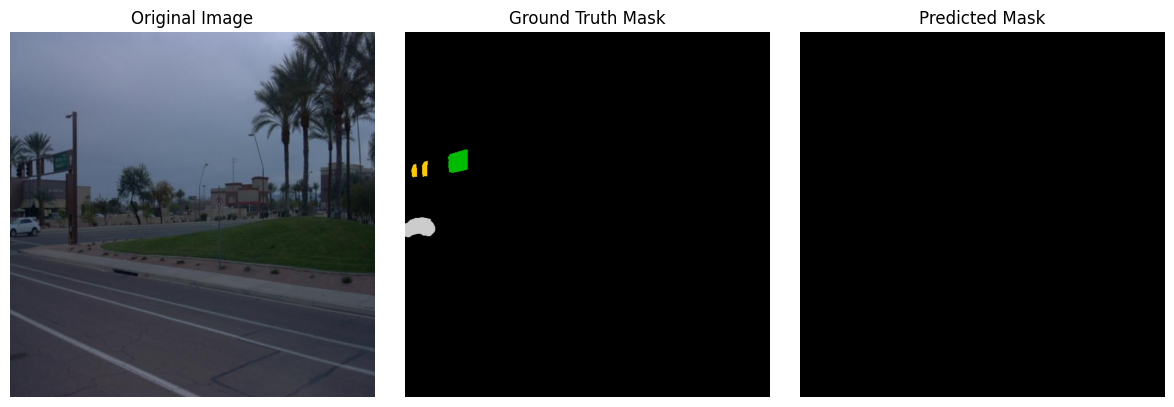

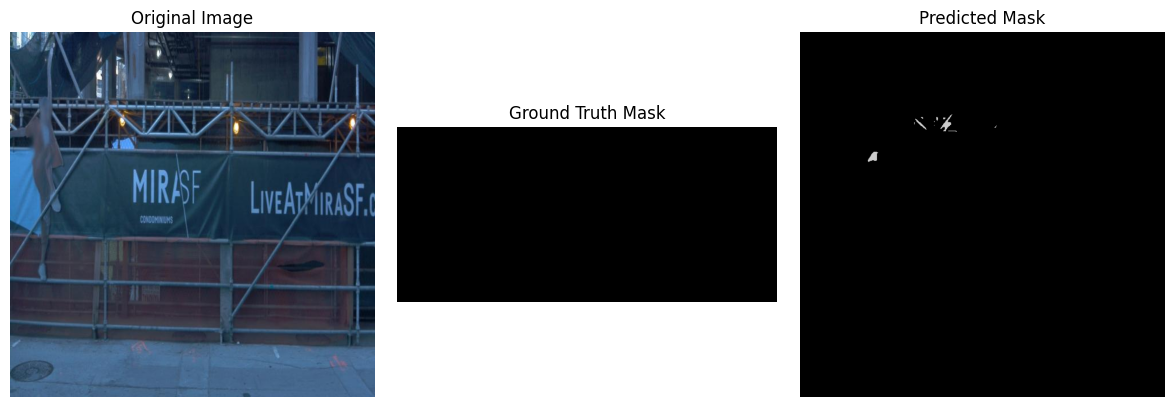

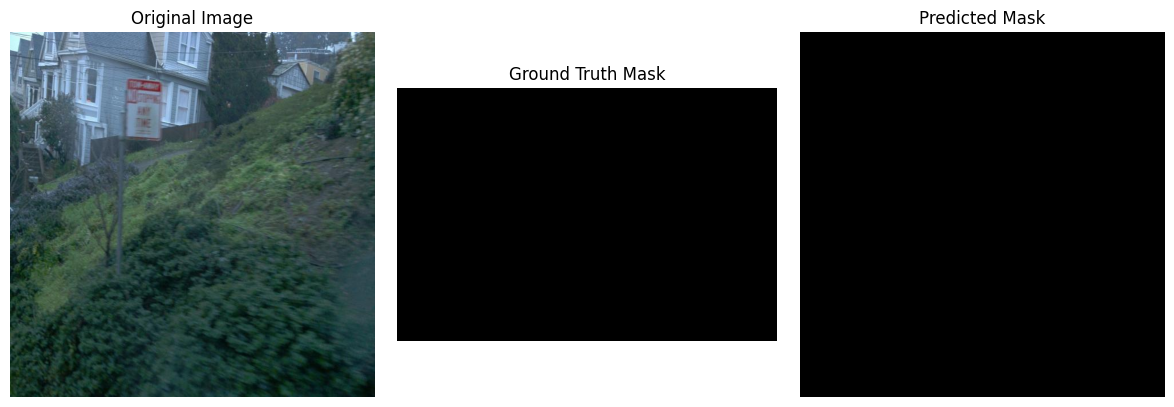

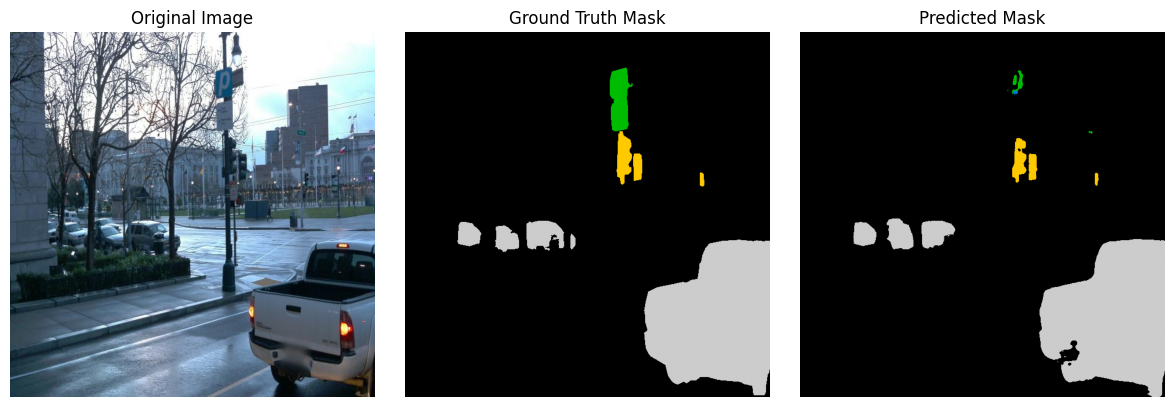

In [ ]:
for i, image_name in enumerate(test_images[:10]):
    image_path = os.path.join(test_folder, image_name)
    image = cv2.imread(image_path)

    mask_path = os.path.join(test_folder, image_name.replace('.jpg', '_mask.png'))
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    pred_mask_path = os.path.join(output_folder, image_name.replace('.jpg', '_class_mask.png'))
    pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='nipy_spectral')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='nipy_spectral')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import shutil

s_f = '/content/AV_semantic_segmentation_best.keras'
d_f = '/content/drive/My Drive/AV_semantic_segmentation_best.keras'

shutil.copy(s_f, d_f)
print(f"File copied to {d_f}")


File copied to /content/drive/My Drive/AV_semantic_segmentation_best.keras
